In [1]:
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from transformers import DebertaV2Tokenizer, DebertaV2Model
from sklearn.utils import shuffle

dataset = load_dataset("lmsys/lmsys-arena-human-preference-55k")

label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
name2label = {v: k for k, v in label2name.items()}

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
        num_rows: 57477
    })
})

In [2]:
model_to_idx = {'gpt-4-0125-preview': 0,
 'nous-hermes-2-mixtral-8x7b-dpo': 1,
 'stablelm-tuned-alpha-7b': 2,
 'starling-lm-7b-alpha': 3,
 'qwen1.5-4b-chat': 4,
 'mistral-7b-instruct': 5,
 'wizardlm-70b': 6,
 'gpt-4-0314': 7,
 'mixtral-8x7b-instruct-v0.1': 8,
 'mpt-7b-chat': 9,
 'claude-2.0': 10,
 'vicuna-7b': 11,
 'claude-1': 12,
 'wizardlm-13b': 13,
 'gpt-4-1106-preview': 14,
 'mistral-7b-instruct-v0.2': 15,
 'qwen1.5-72b-chat': 16,
 'gpt-4-0613': 17,
 'dolphin-2.2.1-mistral-7b': 18,
 'mistral-medium': 19,
 'qwen1.5-7b-chat': 20,
 'llama-2-7b-chat': 21}

model_to_name = {v: k for k, v in model_to_idx.items()}
print(model_to_name)

{0: 'gpt-4-0125-preview', 1: 'nous-hermes-2-mixtral-8x7b-dpo', 2: 'stablelm-tuned-alpha-7b', 3: 'starling-lm-7b-alpha', 4: 'qwen1.5-4b-chat', 5: 'mistral-7b-instruct', 6: 'wizardlm-70b', 7: 'gpt-4-0314', 8: 'mixtral-8x7b-instruct-v0.1', 9: 'mpt-7b-chat', 10: 'claude-2.0', 11: 'vicuna-7b', 12: 'claude-1', 13: 'wizardlm-13b', 14: 'gpt-4-1106-preview', 15: 'mistral-7b-instruct-v0.2', 16: 'qwen1.5-72b-chat', 17: 'gpt-4-0613', 18: 'dolphin-2.2.1-mistral-7b', 19: 'mistral-medium', 20: 'qwen1.5-7b-chat', 21: 'llama-2-7b-chat'}


In [3]:
import re
import json 

model_id = 'microsoft/deberta-v3-base'

tokenizer = DebertaV2Tokenizer.from_pretrained(model_id)
sep_token = tokenizer.sep_token
model_ids_to_filter = ['gpt-4-0125-preview', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-1106-preview',
 'llama-2-7b-chat', 'mistral-7b-instruct', 'mistral-7b-instruct-v0.2', 'mixtral-8x7b-instruct-v0.1',
 'mpt-7b-chat', 'nous-hermes-2-mixtral-8x7b-dpo', 'qwen1.5-4b-chat', 'qwen1.5-7b-chat', 'mistral-medium','claude-1', 'claude-2.0',
    'qwen1.5-72b-chat', 'dolphin-2.2.1-mistral-7b', 'stablelm-tuned-alpha-7b', 'starling-lm-7b-alpha', 'wizardlm-70b', 
                       'wizardlm-13b', 'vicuna-7b']

def clean_text(text):
    text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text)
    text = re.sub(r'[^*\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
    
train_prompts = []
train_responses_a = []
train_responses_b = []
train_labels = []
train_data_text_a = []
train_data_text_b = []
train_model_ids_a = []
train_model_ids_b = []

train_unique_model_ids = set()

for example in tqdm(dataset['train']):
    if example['model_a'] in model_ids_to_filter and example['model_b'] in model_ids_to_filter:
        train_unique_model_ids.add(example['model_a'])
        train_unique_model_ids.add(example['model_b'])

model_to_idx = {model: idx for idx, model in enumerate(train_unique_model_ids)}

for example in tqdm(dataset['train']):
    if example['model_a'] in model_ids_to_filter and example['model_b'] in model_ids_to_filter:
        prompt_arr = json.loads(example['prompt'])
        response_a_arr = json.loads(example['response_a'])
        response_b_arr = json.loads(example['response_b'])

        if (len(response_a_arr) == 1) and (response_a_arr[-1] is not None) and (response_b_arr[-1] is not None):
            clean_prompt = clean_text(prompt_arr[-1])
            clean_a = clean_text(response_a_arr[-1])
            clean_b = clean_text(response_b_arr[-1])
            
            train_model_ids_a.append(model_to_idx[example['model_a']])
            train_model_ids_b.append(model_to_idx[example['model_b']])
    
            train_prompts.append(clean_prompt)
            train_responses_a.append(clean_a)
            train_responses_b.append(clean_b)
    
            train_data_text_a.append(clean_prompt + sep_token + clean_a)
            train_data_text_b.append(clean_prompt + sep_token + clean_b)
    
            if example['winner_model_a'] == 1:
                train_labels.append(name2label['winner_model_a'])
            elif example['winner_model_b'] == 1:
                train_labels.append(name2label['winner_model_b'])
            else:
                train_labels.append(name2label['winner_tie'])
train_size = 6200

df = pd.DataFrame({
    'text1': train_data_text_a,
    'text2': train_data_text_b,
    'label': train_labels, 
    'model_id1': train_model_ids_a,
    'model_id2': train_model_ids_b
})

'''
df_val = pd.DataFrame({
    'text1': val_data_text_a,
    'text2': val_data_text_b,
    'label': val_labels, 
    'model_id1': val_model_ids_a,
    'model_id2': val_model_ids_b
})
'''
random_seed = 40
df = shuffle(df, random_state=random_seed).reset_index(drop=True)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:]
#val_df = df.iloc[train_size:train_size+test_size]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57477/57477 [00:05<00:00, 10839.15it/s]


In [4]:
val_df.shape()

,text1,text2,label,model_id1,model_id2
6200,Paraphrase and give me a short (under 80 words...,Paraphrase and give me a short (under 80 words...,0,1,0
6201,Why would someone ask for advice about giving ...,Why would someone ask for advice about giving ...,2,20,6
6202,talk about about computer architecture[SEP]Com...,talk about about computer architecture[SEP]Com...,1,0,3
6203,Please write a debate between Epicurus and Pet...,Please write a debate between Epicurus and Pet...,0,6,3
6204,guide me step by step in a guide to build a th...,guide me step by step in a guide to build a th...,1,13,16


In [5]:
import json

file_path = './all_model_ids.txt'

data = []

with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if '(' in line and ')' in line:
            parts = line.strip().strip('(),').split(',')
            model_id1 = parts[0].strip().strip("'")
            model_id2 = parts[1].strip().strip("'")
            data.append((model_id1, model_id2))

df = pd.DataFrame(data, columns=['Model ID 1', 'Model ID 2'])

df['preferred response'] = val_df['label'].tolist()

In [6]:
df.head()

,Model ID 1,Model ID 2,preferred response
0,claude-1,gpt-4-0613,0
1,gpt-4-0314,gpt-4-1106-preview,2
2,gpt-4-0613,mistral-medium,1
3,gpt-4-1106-preview,mistral-medium,0
4,gpt-4-0125-preview,claude-2.0,1


In [7]:
import json

file_path = './global_scores.json'

with open(file_path, 'r') as file:
    data = json.load(file)

logits = []
i = 13 # 13 is the best one 
one_eval = data[i]
for i in range(len(one_eval)):
    sample = one_eval[i]
    model_a_logit = sample[0]
    model_b_logit = sample[1]
    tie_logit = sample[2]
    logits.append((model_a_logit, model_b_logit, tie_logit))

df_2 = pd.DataFrame(logits, columns=['Model A logit', 'Model B logit', 'Tie Logit'])

if len(df) == len(df_2):
    df_combined = pd.concat([df, df_2], axis=1)
else:
    print("DataFrames do not have the same number of rows.")


In [8]:
df_combined.head()

,Model ID 1,Model ID 2,preferred response,Model A logit,Model B logit,Tie Logit
0,claude-1,gpt-4-0613,0,0.078722,0.281244,0.026035
1,gpt-4-0314,gpt-4-1106-preview,2,0.194425,0.730182,0.026035
2,gpt-4-0613,mistral-medium,1,0.237326,-0.142835,0.026035
3,gpt-4-1106-preview,mistral-medium,0,0.739730,-0.122341,0.026035
4,gpt-4-0125-preview,claude-2.0,1,0.638031,0.046686,0.026035


In [9]:
large_models = ['gpt-4-0125-preview', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-1106-preview', 'mistral-medium', 
                'claude-1', 'qwen1.5-72b-chat', 'wizardlm-70b']
                
small_models = ['llama-2-7b-chat', 'mistral-7b-instruct', 'mistral-7b-instruct-v0.2', 'mixtral-8x7b-instruct-v0.1',  
                'mpt-7b-chat', 'nous-hermes-2-mixtral-8x7b-dpo', 'qwen1.5-4b-chat', 'qwen1.5-7b-chat', 'claude-2.0',
                'dolphin-2.2.1-mistral-7b', 'stablelm-tuned-alpha-7b', 'starling-lm-7b-alpha','wizardlm-13b', 'vicuna-7b']

large_a = []
large_b = []

for i in range(len(list(df['Model ID 1']))):
    large_a.append(list(df['Model ID 1'])[i] in large_models)
    large_b.append(list(df['Model ID 2'])[i] in large_models)

df_filtered = df_combined.loc[np.array(large_a) != np.array(large_b)]

In [10]:
df_filtered.head()

,Model ID 1,Model ID 2,preferred response,Model A logit,Model B logit,Tie Logit
4,gpt-4-0125-preview,claude-2.0,1,0.638031,0.046686,0.026035
5,gpt-4-0314,mixtral-8x7b-instruct-v0.1,2,0.545663,-0.260868,0.026035
6,gpt-4-0613,mixtral-8x7b-instruct-v0.1,1,0.160250,-0.062206,0.026035
7,mpt-7b-chat,gpt-4-0314,2,-0.665219,0.300759,0.026035
8,gpt-4-0613,claude-2.0,2,0.160250,0.113766,0.026035


In [11]:
def is_large_model(model_id):
    return model_id in large_models

small_model_logits = []

for idx, row in df_filtered.iterrows():
    model_a = row['Model ID 1']
    model_b = row['Model ID 2']
    logit_a = row['Model A logit']
    logit_b = row['Model B logit']
    tie_logit = row['Tie Logit']
    
    if model_a in small_models and model_b in large_models:
        small_model_logits.append(logit_a + tie_logit)
    elif model_b in small_models and model_a in large_models:
        small_model_logits.append(logit_b + tie_logit)
    else:
        small_model_logits.append(np.nan)

df_filtered['small_model_logits'] = small_model_logits

/tmp/ipykernel_1276/700559745.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['small_model_logits'] = small_model_logits


In [14]:
df_filtered.head()

,Model ID 1,Model ID 2,preferred response,Model A logit,Model B logit,Tie Logit,small_model_logits
4,gpt-4-0125-preview,claude-2.0,1,0.638031,0.046686,0.026035,0.072721
5,gpt-4-0314,mixtral-8x7b-instruct-v0.1,2,0.545663,-0.260868,0.026035,-0.234833
6,gpt-4-0613,mixtral-8x7b-instruct-v0.1,1,0.160250,-0.062206,0.026035,-0.036171
7,mpt-7b-chat,gpt-4-0314,2,-0.665219,0.300759,0.026035,-0.639184
8,gpt-4-0613,claude-2.0,2,0.160250,0.113766,0.026035,0.139801


In [15]:
large_win_exp = []
small_win_exp = []

for idx, row in df_filtered.iterrows():
    model_a = row['Model ID 1']
    model_b = row['Model ID 2']
    preferred_response = row['preferred response']
    logit_a = row['Model A logit']
    logit_b = row['Model B logit']
    tie_logit = row['Tie Logit']
    
    if (preferred_response == 2):
        large_win_exp.append(1)
        small_win_exp.append(1)
    elif (preferred_response == 0):
        if model_a in large_models:
            large_win_exp.append(1)
            small_win_exp.append(0)
        else:
            large_win_exp.append(0)
            small_win_exp.append(1)
    else:
        if model_b in large_models:
            large_win_exp.append(1)
            small_win_exp.append(0)
        else:
            large_win_exp.append(0)
            small_win_exp.append(1)

In [16]:
df = df_filtered.copy()
df['large_perf_exp'] = np.array(large_win_exp).reshape(-1, 1)
df['small_perf_exp'] = np.array(small_win_exp).reshape(-1, 1)
df['large_cost'] = 3
df['small_cost'] = .3

In [17]:
df.head()

,Model ID 1,Model ID 2,preferred response,Model A logit,Model B logit,Tie Logit,small_model_logits,large_perf_exp,small_perf_exp,large_cost,small_cost
4,gpt-4-0125-preview,claude-2.0,1,0.638031,0.046686,0.026035,0.072721,0,1,3,0.3
5,gpt-4-0314,mixtral-8x7b-instruct-v0.1,2,0.545663,-0.260868,0.026035,-0.234833,1,1,3,0.3
6,gpt-4-0613,mixtral-8x7b-instruct-v0.1,1,0.160250,-0.062206,0.026035,-0.036171,0,1,3,0.3
7,mpt-7b-chat,gpt-4-0314,2,-0.665219,0.300759,0.026035,-0.639184,1,1,3,0.3
8,gpt-4-0613,claude-2.0,2,0.160250,0.113766,0.026035,0.139801,1,1,3,0.3


In [36]:
value_counts = df['large_perf_exp'].value_counts()

# Print the counts
print("Number of 0's:", value_counts.get(0, 0))
print("Number of 1's:", value_counts.get(1, 0))

Number of 0's: 136
Number of 1's: 499


In [19]:
# testing for optimal performance threshold of actual function
large_win_acc = []
small_win_acc = []
max_correct = 0 # number of small_perf_exp correctly found i think
performance_threshold = [0.1] # test different thresholds of logit sum
#best_threshold = performance_threshold[0]

for threshold in performance_threshold:
    correct_predictions = 0
    for pseudo_idx, (idx, row) in enumerate(df.iterrows()):
        model_a = row['Model ID 1']
        model_b = row['Model ID 2']
        preferred_response = row['preferred response']
        small_perf_exp = row['small_perf_exp']
        small_model_logits = row['small_model_logits']

        if (small_model_logits > threshold):
            large_win_acc.append(0)
            small_win_acc.append(1)
        elif (small_model_logits < threshold):
            large_win_acc.append(1)
            small_win_acc.append(0)
        else:
            large_win_acc.append(1)
            small_win_acc.append(1)
        
        #if (small_win_acc[pseudo_idx] == small_perf_exp):
            #correct_predictions += 1
    #if (correct_predictions > max_correct):
        #max_correct = correct_predictions
        #best_threshold = threshold

print(max_correct)
print(best_threshold)

0


NameError: name 'best_threshold' is not defined

In [20]:
def determine_winner(preferred_response, model_a, model_b, large_models):
    small_model_win_tie = False
    large_model_win_tie = False

    if preferred_response == 2:
        small_model_win_tie = True
        large_model_win_tie = True
    elif preferred_response == 0:
        if model_a in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False
    else:
        if model_b in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False

    return small_model_win_tie, large_model_win_tie

performance_thresholds = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, 
                          0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]   # Test different thresholds of logit sum
performances = []
costs = []

for threshold in performance_thresholds:
    performance = 0
    cost = 0 
    for pseudo_idx, (idx, row) in enumerate(df.iterrows()):
        
        model_a = row['Model ID 1']
        model_b = row['Model ID 2']
        preferred_response = row['preferred response']
        small_perf_exp = row['small_perf_exp']
        small_model_logits = row['small_model_logits']
        small_cost = row['small_cost']
        large_cost = row['large_cost']

        small_model_win_tie, large_model_win_tie = determine_winner(preferred_response, model_a, model_b, large_models)

        if small_model_logits > threshold:
            if small_model_win_tie:
                performance += 1
            cost += small_cost
        else:
            if large_model_win_tie:
                performance += 1
            cost += large_cost

    performance /= len(df)
    #cost /= len(df)

    performances.append(performance)
    costs.append(cost)

    print(f'Performance: {performance}, Cost: {cost}, Threshold: {threshold}')


Performance: 0.5480314960629922, Cost: 247.20000000000263, Threshold: -0.9
Performance: 0.5606299212598426, Cost: 295.8000000000032, Threshold: -0.7
Performance: 0.6236220472440945, Cost: 525.3000000000027, Threshold: -0.5
Performance: 0.6346456692913386, Cost: 576.6000000000004, Threshold: -0.3
Performance: 0.6598425196850394, Cost: 884.399999999994, Threshold: -0.2
Performance: 0.662992125984252, Cost: 1070.6999999999923, Threshold: -0.15
Performance: 0.6818897637795276, Cost: 1232.6999999999937, Threshold: -0.1
Performance: 0.7307086614173228, Cost: 1499.9999999999957, Threshold: 0
Performance: 0.7370078740157481, Cost: 1532.399999999996, Threshold: 0.05
Performance: 0.7700787401574803, Cost: 1764.5999999999985, Threshold: 0.1
Performance: 0.7858267716535433, Cost: 1905, Threshold: 0.3
Performance: 0.7858267716535433, Cost: 1905, Threshold: 0.5
Performance: 0.7858267716535433, Cost: 1905, Threshold: 0.7
Performance: 0.7858267716535433, Cost: 1905, Threshold: 0.9
Performance: 0.78582

In [100]:
def determine_winner(preferred_response, model_a, model_b, large_models):
    small_model_win_tie = False
    large_model_win_tie = False

    if preferred_response == 2:
        small_model_win_tie = True
        large_model_win_tie = True
    elif preferred_response == 0:
        if model_a in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False
    else:
        if model_b in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False

    return small_model_win_tie, large_model_win_tie
    
performance_thresholds = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, 
                          0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0] 

#max_cost_values = [0.1, 10, 100, 200, 300, 2000]
max_cost_values = [2000]
performances = []
costs = []
thresholds = []

results = {}
for threshold in performance_thresholds:
    results[threshold] = {"performance": [], "cost": []}
    for max_cost_per_response in max_cost_values:
        performance = 0
        total_cost = 0
        num_sample = 0

        for pseudo_idx, (idx, row) in enumerate(df.iterrows()):
            num_sample += 1
            curr_max_cost_per_response = max_cost_per_response
            sample_cost = 0

            model_a = row['Model ID 1']
            model_b = row['Model ID 2']
            preferred_response = row['preferred response']
            small_perf_exp = row['small_perf_exp']
            small_model_logits = row['small_model_logits']
            small_cost = row['small_cost']
            large_cost = row['large_cost']

            small_model_win_tie, large_model_win_tie = determine_winner(preferred_response, model_a, model_b, large_models)

            if small_model_logits > threshold:
                if small_model_win_tie:
                    performance += 1
                if sample_cost + small_cost > curr_max_cost_per_response:
                    break
                sample_cost += small_cost
            else:
                if large_model_win_tie:
                    performance += 1
                if sample_cost + large_cost > curr_max_cost_per_response:
                    break
                sample_cost += large_cost
            
            total_cost += sample_cost
            curr_max_cost_per_response -= sample_cost

        performance /= num_sample

        results[threshold]["performance"].append(performance)
        results[threshold]["cost"].append(total_cost)

        print(f'Performance: {performance}, Cost: {total_cost}, Threshold: {threshold}, Max Cost per Response: {max_cost_per_response}')

# Example of how to access and print the results
for threshold in results:
    print(f"Threshold: {threshold}")
    for idx, max_cost in enumerate(max_cost_values):
        costs.append(results[threshold]["cost"][idx])
        performances.append(results[threshold]["performance"][idx])
        thresholds.append(threshold)
        print(f"  Max Cost per Response: {max_cost}")
        print(f"  Average Performance: {results[threshold]['performance'][idx]}")
        print(f"  Total Cost: {results[threshold]['cost'][idx]}")
        print('----------------------')


Performance: 0.5480314960629922, Cost: 247.20000000000263, Threshold: -1.0, Max Cost per Response: 2000
Performance: 0.5480314960629922, Cost: 247.20000000000263, Threshold: -0.9, Max Cost per Response: 2000
Performance: 0.5480314960629922, Cost: 247.20000000000263, Threshold: -0.8, Max Cost per Response: 2000
Performance: 0.5606299212598426, Cost: 295.8000000000032, Threshold: -0.7, Max Cost per Response: 2000
Performance: 0.6157480314960629, Cost: 449.70000000000414, Threshold: -0.6, Max Cost per Response: 2000
Performance: 0.6236220472440945, Cost: 525.3000000000027, Threshold: -0.5, Max Cost per Response: 2000
Performance: 0.6330708661417322, Cost: 557.7000000000014, Threshold: -0.4, Max Cost per Response: 2000
Performance: 0.6346456692913386, Cost: 576.6000000000004, Threshold: -0.3, Max Cost per Response: 2000
Performance: 0.6598425196850394, Cost: 884.399999999994, Threshold: -0.2, Max Cost per Response: 2000
Performance: 0.662992125984252, Cost: 1070.6999999999923, Threshold: -

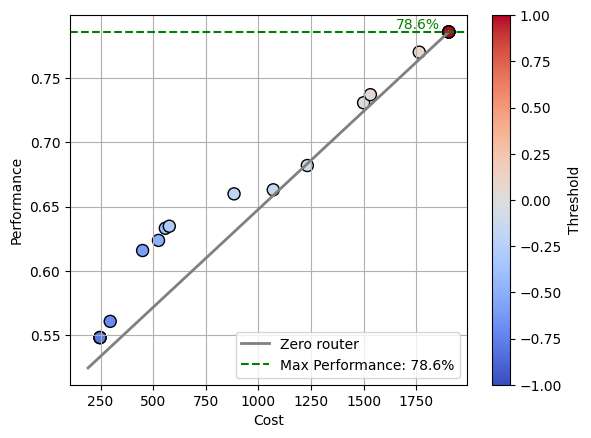

In [101]:
# Create output directory if it doesn't exist
output_dir = "./png"
os.makedirs(output_dir, exist_ok=True)

# create zero router
zero_router_costs = [190.5, 1905]
zero_router_performance = [333/635, 499/635]

'''
def func(x):
    return 0.000152474379023*x+0.495363079615
max_diff = 0
max_diff_idx = 0
for i in range(len(performances)):
    diff = performances[i]- func(costs[i])
    if diff > max_diff:
        max_diff = diff
        max_diff_idx = i
val = performances[max_diff_idx]
'''
# Plotting
output_file = os.path.join(output_dir, "routing_current_model_no_max_cost.png")
plt.figure()
#scatter = plt.scatter(costs, performances, c=thresholds, cmap='coolwarm', edgecolor='k', s=75)
scatter = plt.scatter(costs, performances, c=thresholds, cmap='coolwarm', edgecolor='k', s=75)
#plt.plot(costs, performances, color='red', linewidth=1.5)
plt.plot(zero_router_costs, zero_router_performance, color='gray', linewidth=2, label='Zero router')  # Zero router line
max_performance = max(performances)
plt.axhline(y=max_performance, color='green', linestyle='--', linewidth=1.5, label=f'Max Performance: {100*max_performance:.1f}%')
plt.text(costs[-1] - 250, max_performance, f'{100*max_performance:.1f}%', va='bottom', ha='left', color='green')

#plt.axhline(y=val, color='purple', linestyle='--', linewidth=1.5, label=f'Max Difference Level: {100*val:.1f}%')
#plt.text(costs[-1] - 250, val, f'{100*val:.1f}%', va='bottom', ha='left', color='purple')

plt.colorbar(scatter, label='Threshold')
plt.xlabel('Cost')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.savefig(output_file)
plt.show()

In [102]:
def determine_winner(preferred_response, model_a, model_b, large_models):
    small_model_win_tie = False
    large_model_win_tie = False

    if preferred_response == 2:
        small_model_win_tie = True
        large_model_win_tie = True
    elif preferred_response == 0:
        if model_a in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False
    else:
        if model_b in large_models:
            small_model_win_tie = False
            large_model_win_tie = True
        else:
            small_model_win_tie = True
            large_model_win_tie = False

    return small_model_win_tie, large_model_win_tie

performance_thresholds = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, 
                          0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0] 
#performance_thresholds = [0]
'''
max_cost_values = [0.4, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
                   1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 
                   4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 7.0, 8.0, 8.5, 9.0, 9.5, 10.0, 200, 300]
'''
max_cost_values = [0.01, 0.1, 0.4, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
                   1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 
                   4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 7.0, 8.0, 8.5, 9.0, 9.5, 10.0]
#max_cost_values = [2000]
performances = []
costs = []
thresholds = []

results = {}
for threshold in performance_thresholds:
    results[threshold] = {"performance": [], "cost": []}
    for max_cost_per_response in max_cost_values:
        performance = 0
        total_cost = 0
        num_sample = 0

        for pseudo_idx, (idx, row) in enumerate(df.iterrows()):
            num_sample += 1
            curr_max_cost_per_response = max_cost_per_response
            sample_cost = 0

            model_a = row['Model ID 1']
            model_b = row['Model ID 2']
            preferred_response = row['preferred response']
            small_perf_exp = row['small_perf_exp']
            small_model_logits = row['small_model_logits']
            small_cost = row['small_cost']
            large_cost = row['large_cost']

            small_model_win_tie, large_model_win_tie = determine_winner(preferred_response, model_a, model_b, large_models)

            if small_model_logits > threshold:
                if small_model_win_tie:
                    performance += 1
                sample_cost += small_cost
            else:
                if large_cost < curr_max_cost_per_response:
                    if large_model_win_tie:
                        performance += 1
                    sample_cost += large_cost
                else:
                     if small_model_win_tie:
                        performance += 1
                     sample_cost += small_cost
            
            total_cost += sample_cost
            curr_max_cost_per_response -= sample_cost

        performance /= num_sample

        results[threshold]["performance"].append(performance)
        results[threshold]["cost"].append(total_cost)

        print(f'Performance: {performance}, Cost: {total_cost}, Threshold: {threshold}, Max Cost per Response: {max_cost_per_response}')

# Example of how to access and print the results
for threshold in results:
    print(f"Threshold: {threshold}")
    for idx, max_cost in enumerate(max_cost_values):
        costs.append(results[threshold]["cost"][idx])
        performances.append(results[threshold]["performance"][idx])
        thresholds.append(threshold)
        print(f"  Max Cost per Response: {max_cost}")
        print(f"  Average Performance: {results[threshold]['performance'][idx]}")
        print(f"  Total Cost: {results[threshold]['cost'][idx]}")
        print('----------------------')

Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.01
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.1
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.4
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.5
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.55
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.6
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.65
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.75
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max Cost per Response: 0.8
Performance: 0.5244094488188976, Cost: 190.5000000000015, Threshold: -1.0, Max

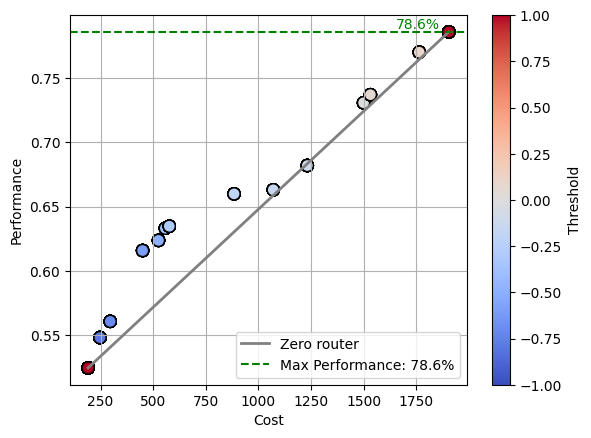

In [103]:
output_file = os.path.join(output_dir, "routing_current_model_max_costs.png")
plt.figure()
scatter = plt.scatter(costs, performances, c=thresholds, cmap='coolwarm', edgecolor='k', s=75)
plt.plot(zero_router_costs, zero_router_performance, color='gray', linewidth=2, label='Zero router')  # Zero router line
max_performance = max(performances)
plt.axhline(y=max_performance, color='green', linestyle='--', linewidth=1.5, label=f'Max Performance: {100*max_performance:.1f}%')
plt.text(costs[-1] - 250, max_performance, f'{100*max_performance:.1f}%', va='bottom', ha='left', color='green')
plt.colorbar(scatter, label='Threshold')
plt.xlabel('Cost')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.savefig(output_file)
plt.show()

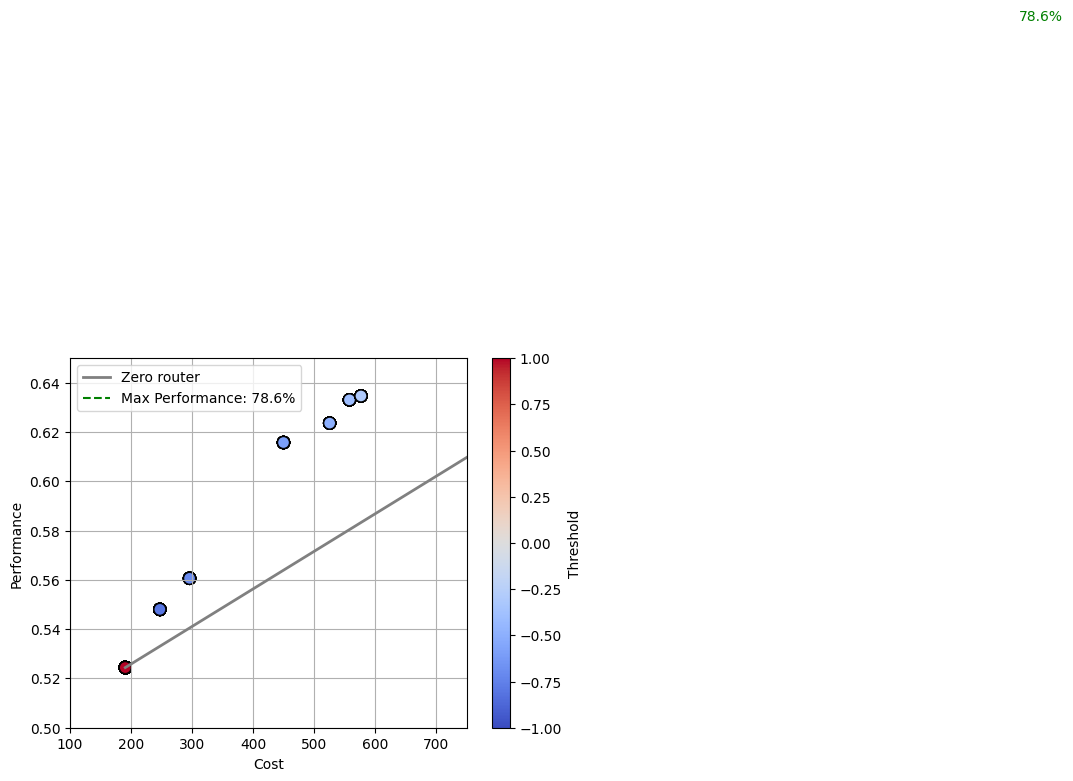

In [106]:
import os
import matplotlib.pyplot as plt

output_file = os.path.join(output_dir, "routing_current_model_max_costs_zoomed.png")

# Define the zoomed in region limits
x_min, x_max = 100, 750  # Adjust these values as needed
y_min, y_max = 0.50, 0.65  # Adjust these values as needed

plt.figure()
scatter = plt.scatter(costs, performances, c=thresholds, cmap='coolwarm', edgecolor='k', s=75)
plt.plot(zero_router_costs, zero_router_performance, color='gray', linewidth=2, label='Zero router')  # Zero router line
max_performance = max(performances)
plt.axhline(y=max_performance, color='green', linestyle='--', linewidth=1.5, label=f'Max Performance: {100*max_performance:.1f}%')
plt.text(costs[-1] - 250, max_performance, f'{100*max_performance:.1f}%', va='bottom', ha='left', color='green')
plt.colorbar(scatter, label='Threshold')
plt.xlabel('Cost')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()

# Set the zoomed in region limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.savefig(output_file)
plt.show()


In [29]:
models_to_route = ['small', 'large']

performance_threshold = 0.75

evaluator_error_rates = [0.0, 0.01, 0.05, 0.1, 0.2, 0.4]

max_cost_values = [0.01, 0.1, 0.4, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
                   1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 
                   4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 7.0, 8.0, 8.5, 9.0, 9.5, 10.0]

results = {error_rate: {max_cost: {"performance": [], "cost": []} for max_cost in max_cost_values} for error_rate in evaluator_error_rates}


In [30]:
error_rate = 0
max_cost_per_response = 10

In [33]:
for error_rate in evaluator_error_rates:
    for max_cost_per_response in max_cost_values:
        
        eval_set_total_performance_score = 0
        total_cost = 0
        num_sample = 0

        for idx, row in df.iterrows():
            num_sample += 1
            curr_max_cost_per_response = max_cost_per_response
            sample_cost = 0
            last_performance = 0

            for model_prefix in models_to_route:
                model_performance = row[model_prefix + '_perf_exp'] # for the ideal ones
                model_total_cost = row[model_prefix + '_cost']

                if model_total_cost >= curr_max_cost_per_response and sample_cost > 0:
                    break  # Stop if max cost is exceeded

                # Introduce evaluator error
                evaluator_wrong = np.random.rand() < error_rate
                sample_cost += model_total_cost
                curr_max_cost_per_response -= model_total_cost

                if evaluator_wrong:
                    answer_accepted = 1-model_performance >= performance_threshold
                else:
                    answer_accepted = model_performance >= performance_threshold

                last_performance = model_performance

                if answer_accepted:
                    break

            eval_set_total_performance_score += last_performance
            total_cost += sample_cost

        avg_performance = eval_set_total_performance_score / num_sample
        results[error_rate][max_cost_per_response]["performance"].append(avg_performance)
        '''
        print(max_cost_per_response)
        print('----------------------')
        print(results[error_rate][max_cost_per_response]["performance"])
        '''
        results[error_rate][max_cost_per_response]["cost"].append(total_cost)

Error Rate: 0.0, Max Cost: 0.01, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.1, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.4, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.5, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.55, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.6, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.65, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.75, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.8, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.85, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.9, Best Threshold: 0.0, Performance: -0.19029212734244
Error Rate: 0.0, Max Cost: 0.95, Best Threshold: 0.0, Performance: -0.1

In [35]:
oracle_cost = 0
for i in range(df.shape[0]):
    if df.small_performance.iloc[i]==1:
        oracle_cost += df.small_cost.iloc[i]
    else:
        oracle_cost += df.large_cost.iloc[i]

AttributeError: 'DataFrame' object has no attribute 'small_performance'

NameError: name 'oracle_cost' is not defined

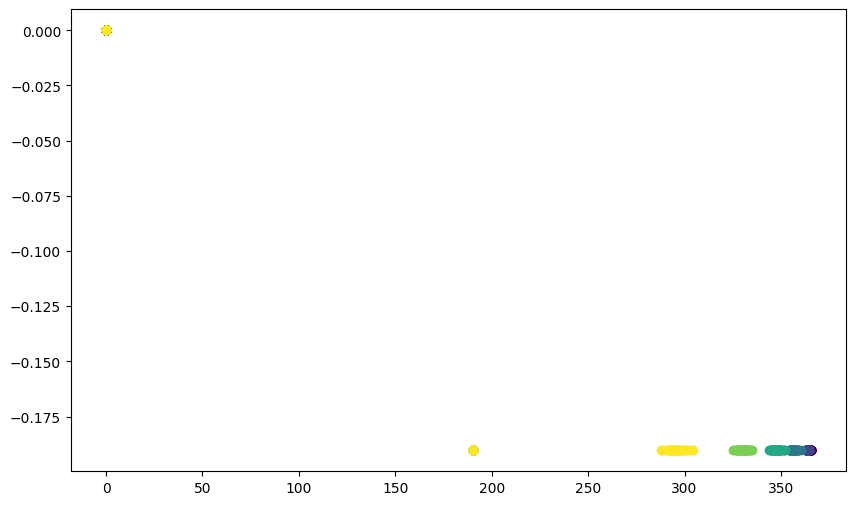

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
output_dir = "./png"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "scoring_function.png")


colors = plt.cm.viridis(np.linspace(0, 1, len(evaluator_error_rates)))
for idx, error_rate in enumerate(evaluator_error_rates):
    costs = [results[error_rate][max_cost]["cost"][0] for max_cost in max_cost_values]
    performances = [results[error_rate][max_cost]["performance"][0] for max_cost in max_cost_values]
    ax.scatter(costs, performances, color=colors[idx], label=f'Error: {error_rate}')

ax.scatter(oracle_cost, 1, color='green', marker='*', s=200, label='Oracle')
ax.set_xlabel('Total Cost ($)')
ax.set_ylabel('Performance')
ax.legend(loc='lower right')

plt.grid(True)
plt.savefig(output_file)
plt.show()

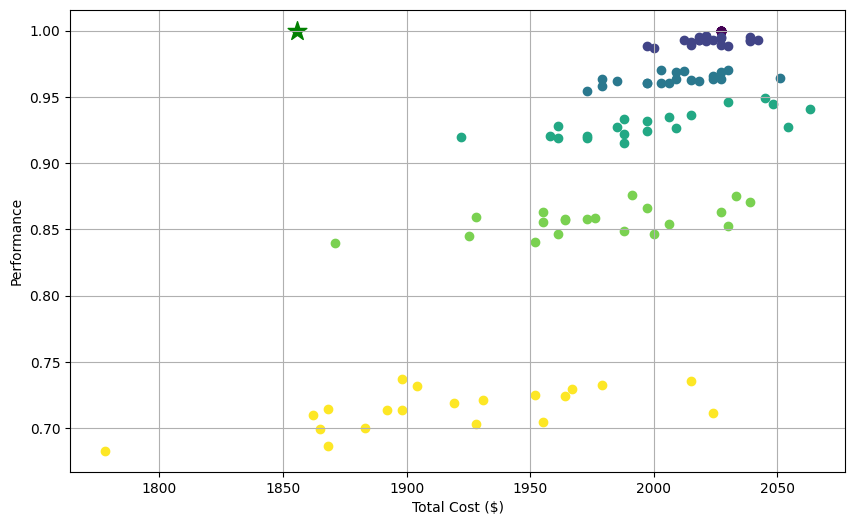

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
output_dir = "./png"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "zoom.png")

colors = plt.cm.viridis(np.linspace(0, 1, len(evaluator_error_rates)))
for idx, error_rate in enumerate(evaluator_error_rates):
    costs = [results[error_rate][max_cost]["cost"][0] for max_cost in max_cost_values]
    performances = [results[error_rate][max_cost]["performance"][0] for max_cost in max_cost_values]
    
    # Filter values where cost > 1000 and performance > 0.5
    filtered_costs = [cost for cost, perf in zip(costs, performances) if cost > 1000 and perf > 0.5]
    filtered_performances = [perf for cost, perf in zip(costs, performances) if cost > 1000 and perf > 0.5]

    extra_cost = costs - filtered_costs
    
    # Add jittering
    x_jitter = x + np.random.normal(0, 10, x.shape)
    y_jitter = y + np.random.normal(0, 0.02, y.shape)
    plt.scatter(x_jitter, y_jitter, color='red', alpha=0.5)
    extra_performances = performances - extra_performances
    
    ax.scatter(filtered_costs, filtered_performances, color=colors[idx], label=f'Error: {error_rate}')

ax.scatter(oracle_cost, 1, color='green', marker='*', s=200, label='Oracle')
ax.set_xlabel('Total Cost ($)')
ax.set_ylabel('Performance')

plt.grid(True)
plt.savefig(output_file)
plt.show()